# Rassembler le dataset dans balanced_dataset

In [11]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm

# --- Réglages ---
root_source = Path("dmandqrdatasetsimple-1")    # dataset YOLO complet (train/val/test)
extra_source = Path("assembled_new_DM_dataset")         # dossier à ajouter
root_target = Path("balanced_dataset")

CLEAR_TARGET = True  # remettre à False si tu veux juste ajouter

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# --- Préparer la sortie ---
images_out = root_target / "images"
labels_out = root_target / "labels"

if CLEAR_TARGET and root_target.exists():
    shutil.rmtree(root_target)

images_out.mkdir(parents=True, exist_ok=True)
labels_out.mkdir(parents=True, exist_ok=True)

used_names = set()

def make_unique_name(stem, ext):
    candidate = f"{stem}{ext}"
    if candidate not in used_names:
        used_names.add(candidate)
        return stem, candidate
    i = 1
    while True:
        candidate = f"{stem}_{i}{ext}"
        if candidate not in used_names:
            used_names.add(candidate)
            return f"{stem}_{i}", candidate
        i += 1

# --- Fusion train/val/test ---
splits = ["train", "valid", "test"]
for split in splits:
    img_dir = root_source / split / "images"
    lbl_dir = root_source / split / "labels"

    if not img_dir.exists():
        continue

    for img_path in tqdm(list(img_dir.iterdir()), desc=f"Copie {split}", unit="img"):
        if img_path.suffix.lower() not in IMG_EXTS:
            continue

        stem, ext = img_path.stem, img_path.suffix.lower()
        stem_with_split = f"{stem}_{split}"
        new_stem, new_img_name = make_unique_name(stem_with_split, ext)

        shutil.copy2(img_path, images_out / new_img_name)

        src_lbl = lbl_dir / f"{stem}.txt"
        if src_lbl.exists():
            shutil.copy2(src_lbl, labels_out / f"{new_stem}.txt")

# --- Copie des images de assembled_testQR ---
print("\n📦 Ajout des images/labels de assembled_testQR...")
extra_img_dir = extra_source / "images"
extra_lbl_dir = extra_source / "labels"

for img_path in tqdm(list(extra_img_dir.iterdir()), desc="Copie assembled_testQR", unit="img"):
    if img_path.suffix.lower() not in IMG_EXTS:
        continue

    stem, ext = img_path.stem, img_path.suffix.lower()
    stem_with_tag = f"{stem}_extra"
    new_stem, new_img_name = make_unique_name(stem_with_tag, ext)

    shutil.copy2(img_path, images_out / new_img_name)

    src_lbl = extra_lbl_dir / f"{stem}.txt"
    if src_lbl.exists():
        shutil.copy2(src_lbl, labels_out / f"{new_stem}.txt")

print("\n✅ Fusion + ajout terminés dans:", root_target.resolve())

Copie test: 100%|██████████| 4561/4561 [00:06<00:00, 735.77img/s] 



📦 Ajout des images/labels de assembled_testQR...


Copie assembled_testQR: 100%|██████████| 6299/6299 [00:06<00:00, 1020.84img/s]


✅ Fusion + ajout terminés dans: /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset


# Analyser la répartition de base du datsaet


## Set up et scan dataset

In [12]:
# Cellule 1 — Imports & chemins
import os
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

DATASET_DIR = Path("balanced_dataset")
IMAGES_DIR = DATASET_DIR / "images"
LABELS_DIR = DATASET_DIR / "labels"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

assert IMAGES_DIR.exists(), f"{IMAGES_DIR} introuvable"
assert LABELS_DIR.exists(), f"{LABELS_DIR} introuvable"

In [13]:
# Cellule 2 — Construire un DataFrame image ↔ label + dataset_origin + bbox_count

rows = []
image_files = [p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in IMG_EXTS]

for img_path in tqdm(image_files, desc="Scan images"):
    stem = img_path.stem   # nom sans extension
    # Préfixe = ce qu'il y a avant le premier underscore
    dataset_origin = stem.split("_")[0] if "_" in stem else "UNKNOWN"

    label_path = LABELS_DIR / f"{stem}.txt"
    if label_path.exists():
        with open(label_path, "r", encoding="utf-8") as f:
            # 1 ligne = 1 bbox (même si classe unique)
            bbox_count = sum(1 for _ in f if _.strip())
    else:
        bbox_count = 0  # image sans label

    rows.append({
        "image": img_path.name,
        "stem": stem,
        "dataset_origin": dataset_origin,
        "label_exists": label_path.exists(),
        "bbox_count": bbox_count
    })

df = pd.DataFrame(rows)
print(df.head())
print(f"\nTotal images: {len(df)} — Labels manquants: {(~df['label_exists']).sum()}")

Scan images: 100%|██████████| 51950/51950 [00:06<00:00, 7805.03it/s]


                                               image  \
0  datamatrixmerged_21022_jpg.rf.14ed3e5450f32f99...   
1  datamatrixmerged_638586338159323690_jpg.rf.3e5...   
2  version2_0opxu_b3qwo_version2-1029-_jpg.rf.955...   
3  datamatrixmerged_1572_jpg.rf.97f4c1dcc6d21db5d...   
4  datamatrixmerged_17573_jpg.rf.110d13882a19edf5...   

                                                stem    dataset_origin  \
0  datamatrixmerged_21022_jpg.rf.14ed3e5450f32f99...  datamatrixmerged   
1  datamatrixmerged_638586338159323690_jpg.rf.3e5...  datamatrixmerged   
2  version2_0opxu_b3qwo_version2-1029-_jpg.rf.955...          version2   
3  datamatrixmerged_1572_jpg.rf.97f4c1dcc6d21db5d...  datamatrixmerged   
4  datamatrixmerged_17573_jpg.rf.110d13882a19edf5...  datamatrixmerged   

   label_exists  bbox_count  
0          True           1  
1          True           1  
2          True           2  
3          True           1  
4          True           1  

Total images: 51950 — Labels manquant

## Répartition globale par dataset d'origine

dataset_origin  images
0    datamatrixmerged   40293
1            version2    2897
2               bcdmp    1788
3                 asd    1489
4                  dm     966
5        2dDataMatrix     891
6                  2D     872
7                  Li     842
8            Detector     450
9          icecream 2     387
10                 2d     199
11               data     180
12       qrcodedetect     138
13                dmc     123
14  OR Code Detection     104
15                 DM      99
16              qrcut      92
17          codes2024      73
18                dpm      50
19                png      17

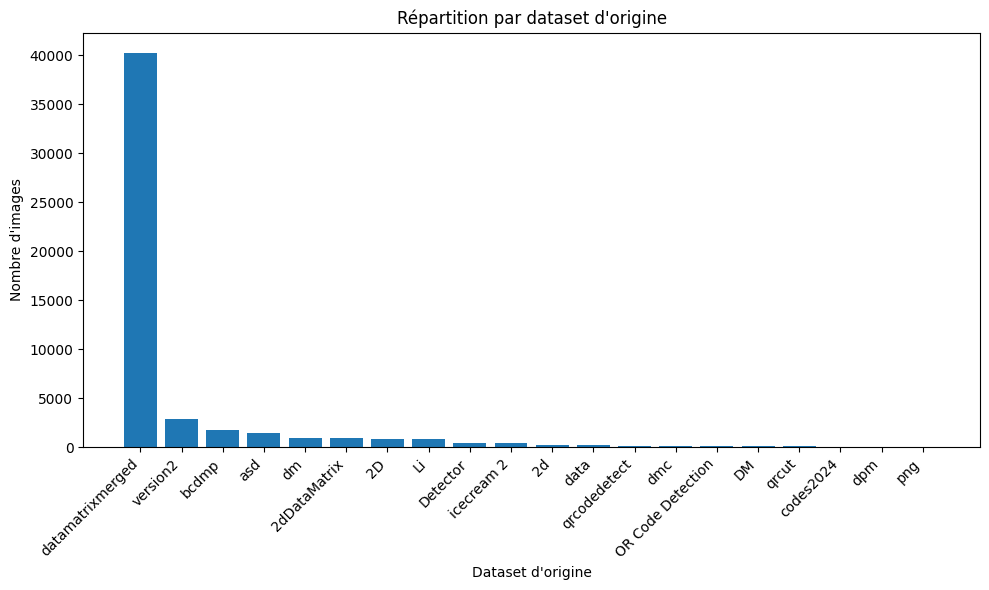

In [25]:
# Cellule 3 — Répartition globale (barres triées décroissant)

counts = df["dataset_origin"].value_counts().reset_index()
counts.columns = ["dataset_origin", "images"]
display(counts)

plt.figure(figsize=(10, 6))
plt.bar(counts["dataset_origin"], counts["images"])
plt.title("Répartition par dataset d'origine")
plt.ylabel("Nombre d'images")
plt.xlabel("Dataset d'origine")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

                  images
datamatrixmerged   40293
autres             11657


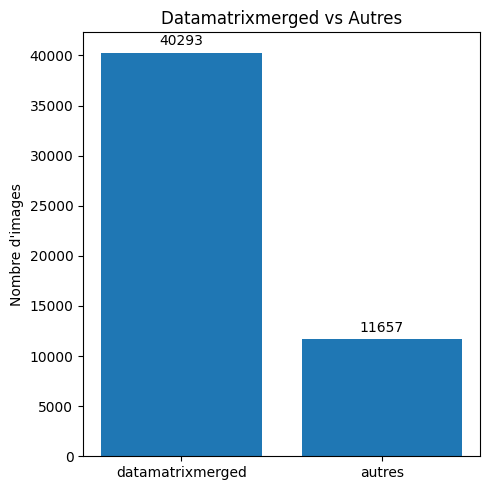

Part de 'datamatrixmerged' : 77.56%


In [15]:
# Cellule 4 — Focus: datamatrixmerged vs tous les autres (pour illustrer la disproportion)

focus = df["dataset_origin"].apply(lambda x: "datamatrixmerged" if x == "datamatrixmerged" else "autres")
focus_counts = focus.value_counts().reindex(["datamatrixmerged", "autres"]).fillna(0)
print(focus_counts.to_frame("images"))

plt.figure(figsize=(5,5))
bars = plt.bar(focus_counts.index, focus_counts.values)
plt.title("Datamatrixmerged vs Autres")
plt.ylabel("Nombre d'images")
for b in bars:
    h = b.get_height()
    plt.annotate(f"{int(h)}", (b.get_x()+b.get_width()/2, h), ha="center", va="bottom", xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.show()

ratio = focus_counts["datamatrixmerged"] / focus_counts.sum() if focus_counts.sum() else 0
print(f"Part de 'datamatrixmerged' : {ratio:.2%}")

## Nombre de bboxes par image — stats par dataset + graphe

In [16]:
# Cellule 5 — Stats par dataset (min / mean / max) du nombre de bboxes par image

stats = (
    df.groupby("dataset_origin")["bbox_count"]
      .agg(["count", "min", "mean", "max"])
      .sort_values("count", ascending=False)
      .reset_index()
)
stats["mean"] = stats["mean"].round(3)
display(stats.head(20))

dataset_origin  count  min   mean  max
0    datamatrixmerged  40293    0  1.217   15
1            version2   2897    0  4.439    9
2               bcdmp   1788    1  6.346   93
3                 asd   1489    0  1.095    4
4                  dm    966    1  3.898   20
5        2dDataMatrix    891    0  1.000    2
6                  2D    872    0  0.987    1
7                  Li    842    0  0.999    1
8            Detector    450    1  1.027    3
9          icecream 2    387    3  5.333    6
10                 2d    199    0  0.935    1
11               data    180    1  1.000    1
12       qrcodedetect    138    1  1.051    5
13                dmc    123    1  1.024    2
14  OR Code Detection    104    1  3.029   55
15                 DM     99    1  1.000    1
16              qrcut     92    1  1.000    1
17          codes2024     73    1  1.466    5
18                dpm     50    1  1.040    2
19                png     17    0  3.765    5

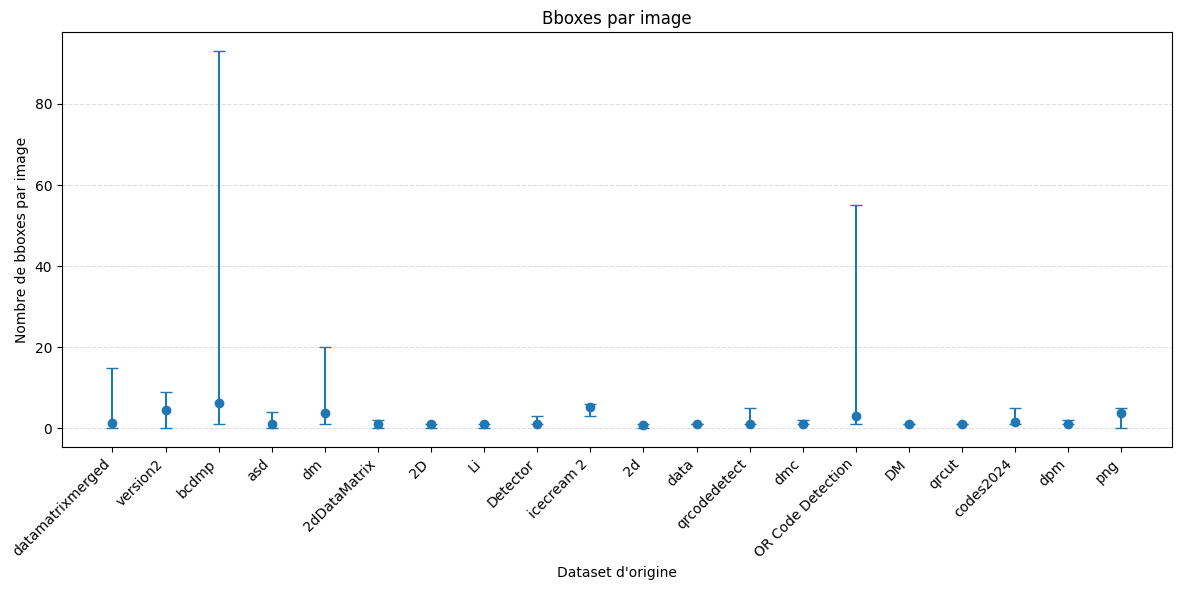

In [26]:
# Cellule 6 — Graphe: moyenne de bboxes/image par dataset avec barres d'erreur (min/max)

x = stats["dataset_origin"]
y = stats["mean"]
yerr_lower = stats["mean"] - stats["min"]
yerr_upper = stats["max"] - stats["mean"]
yerr = [yerr_lower, yerr_upper]

plt.figure(figsize=(12, 6))
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.title("Bboxes par image")
plt.ylabel("Nombre de bboxes par image")
plt.xlabel("Dataset d'origine")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

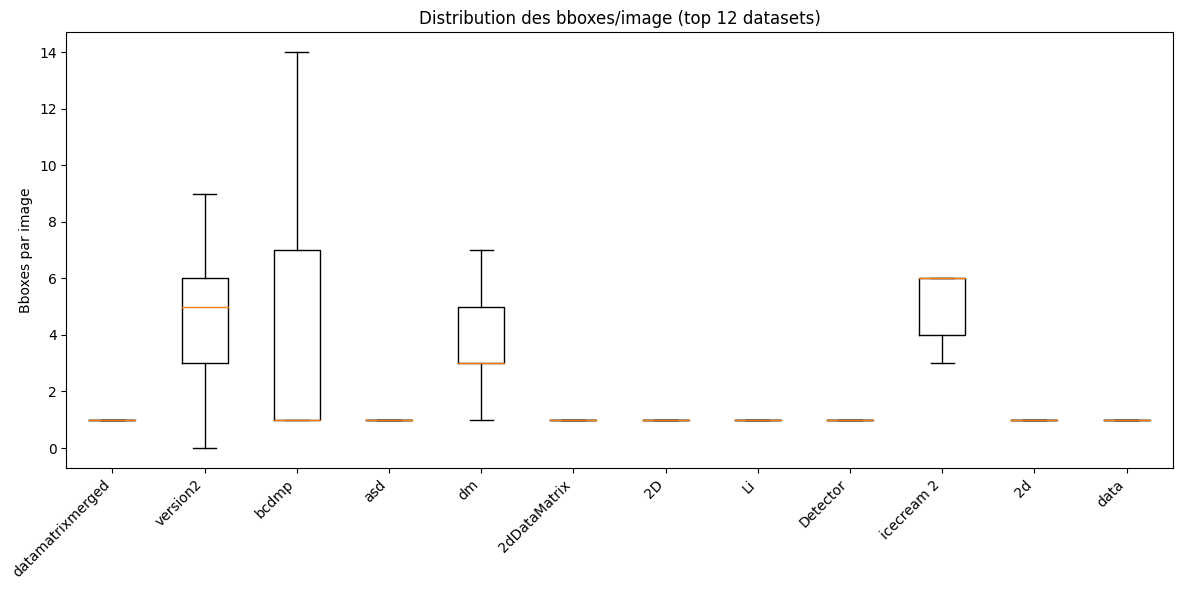

In [18]:
# Cellule 7 — (Optionnel) Boxplot des distributions bboxes/image par dataset (top N pour lisibilité)

TOP_N = 12  # ajuste si besoin
top_datasets = stats["dataset_origin"].head(TOP_N).tolist()

data_for_box = [df.loc[df["dataset_origin"] == ds, "bbox_count"].values for ds in top_datasets]

plt.figure(figsize=(12, 6))
plt.boxplot(data_for_box, labels=top_datasets, showfliers=False)
plt.title(f"Distribution des bboxes/image (top {TOP_N} datasets)")
plt.ylabel("Bboxes par image")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Scan images: 100%|██████████| 51950/51950 [00:07<00:00, 7181.96it/s]


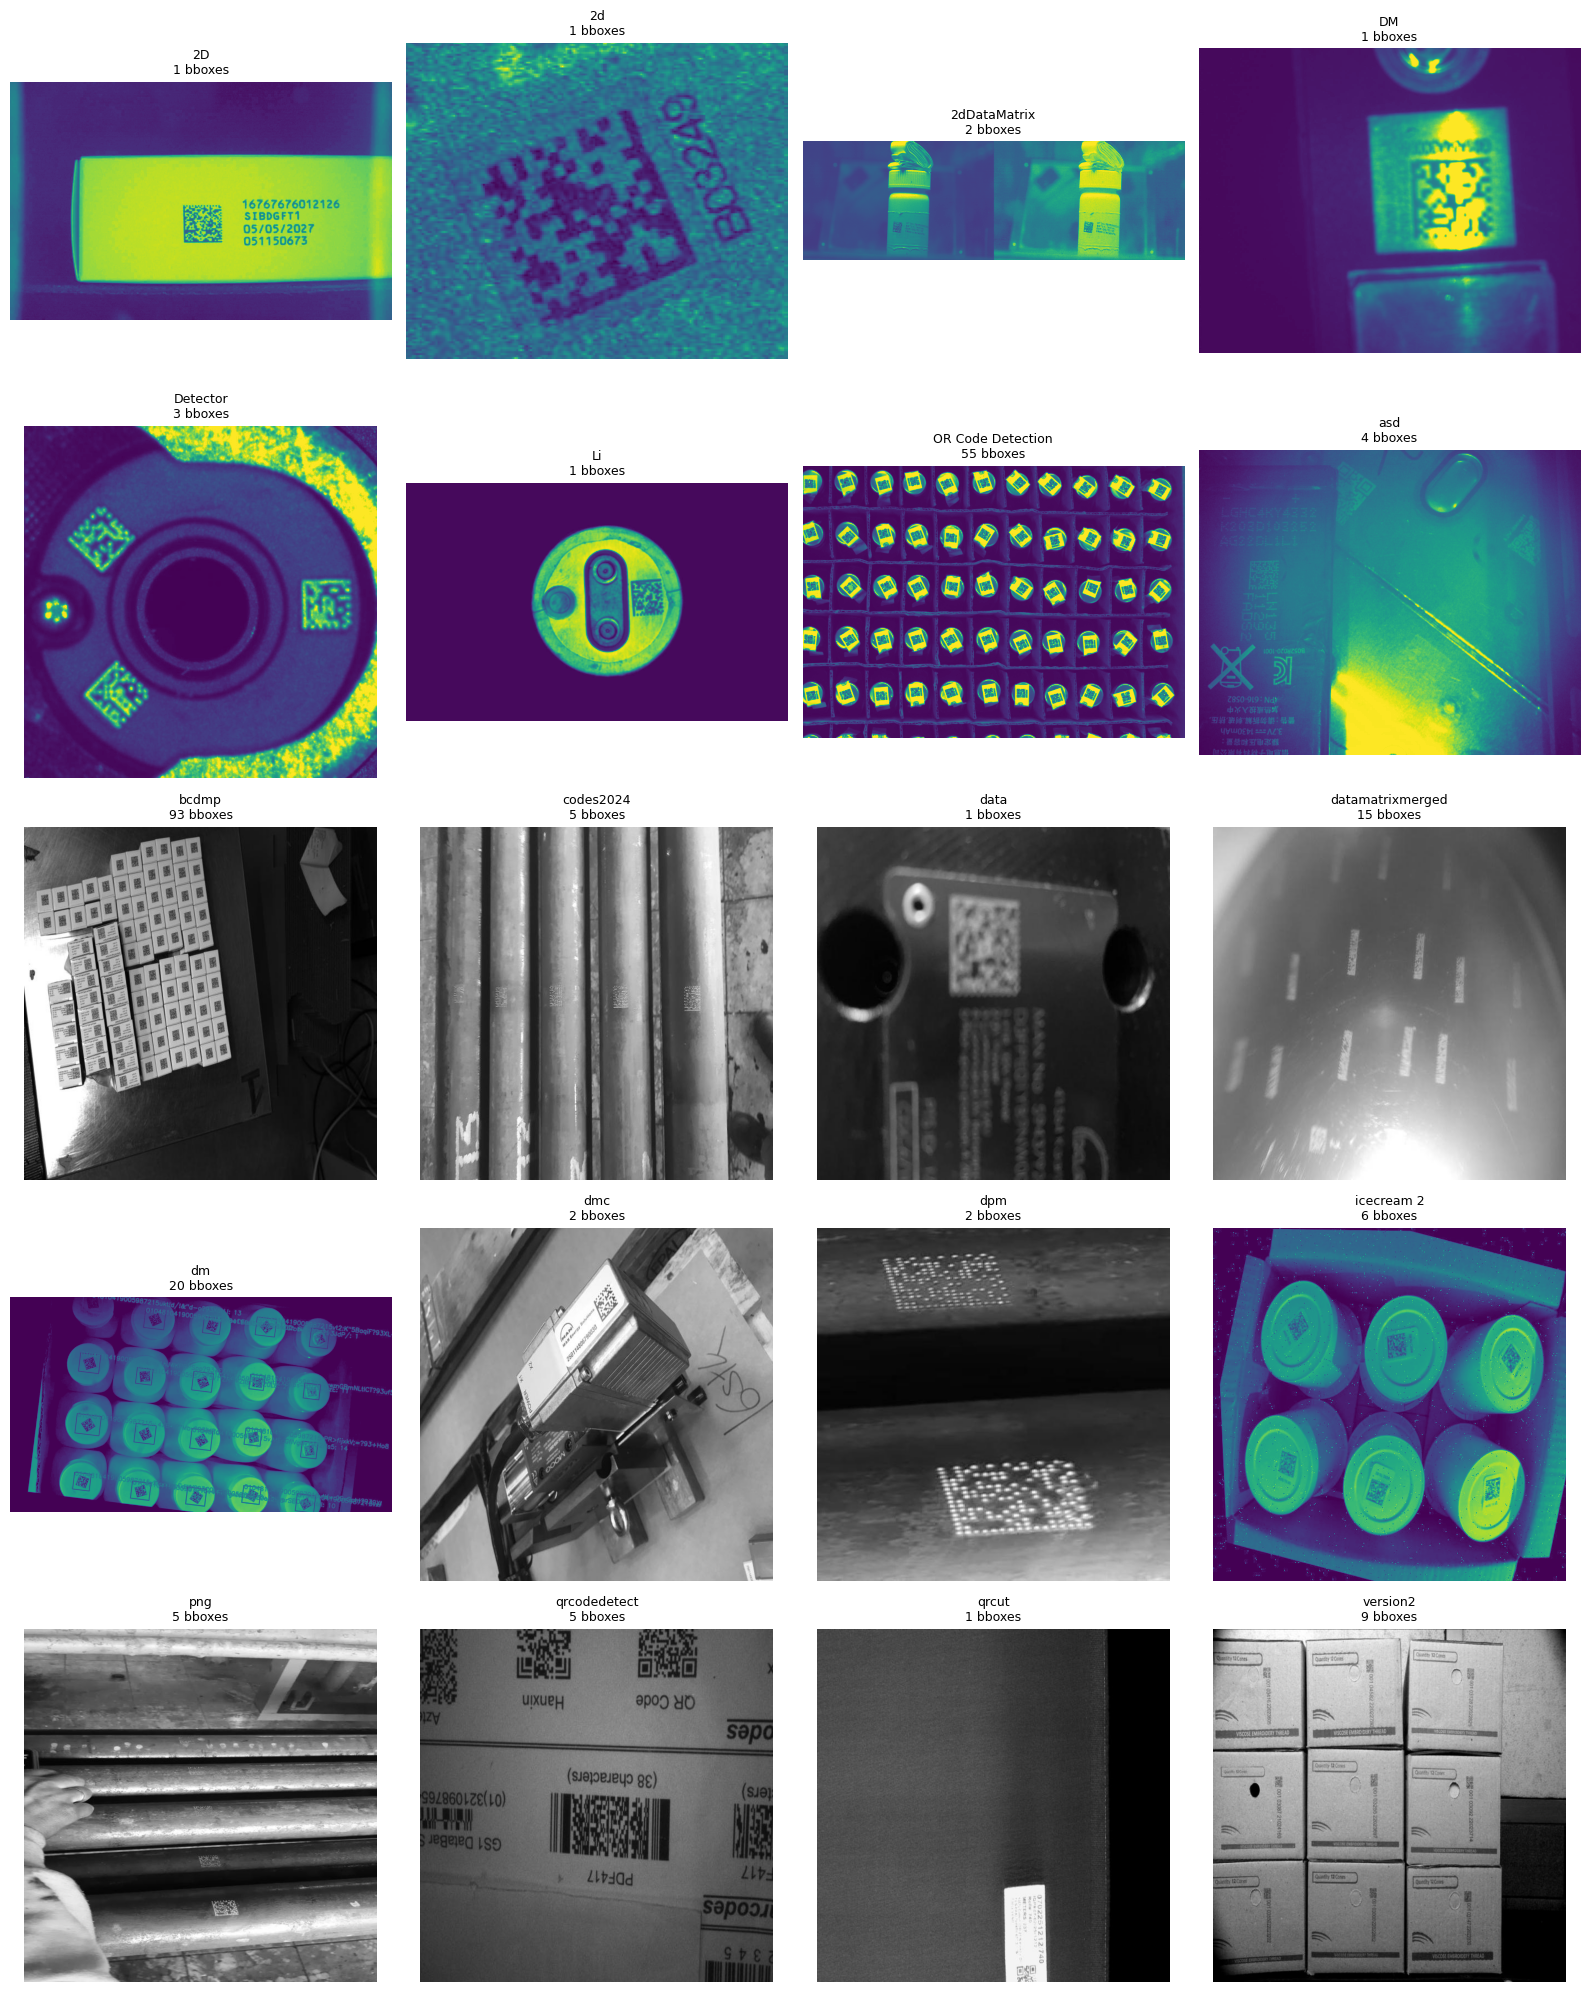

In [20]:
import os
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- Réglages ---
DATASET_DIR = Path("balanced_dataset")
IMAGES_DIR = DATASET_DIR / "images"
LABELS_DIR = DATASET_DIR / "labels"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

assert IMAGES_DIR.exists(), f"{IMAGES_DIR} introuvable"
assert LABELS_DIR.exists(), f"{LABELS_DIR} introuvable"

def count_yolo_bboxes(label_path: Path) -> int:
    """Compte les bboxes (lignes non vides) dans un fichier label YOLO."""
    if not label_path.exists():
        return 0
    with open(label_path, "r", encoding="utf-8") as f:
        return sum(1 for line in f if line.strip())

# 1) Scanner toutes les images et compter bboxes
records = []
for img_path in tqdm([p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in IMG_EXTS], desc="Scan images"):
    stem = img_path.stem
    dataset_origin = stem.split("_")[0] if "_" in stem else "UNKNOWN"
    label_path = LABELS_DIR / f"{stem}.txt"
    bbox_count = count_yolo_bboxes(label_path)

    records.append({
        "dataset_origin": dataset_origin,
        "image": img_path.name,
        "bbox_count": bbox_count,
        "image_path": img_path
    })

df = pd.DataFrame(records)

# 2) Trouver l'image avec le plus de bboxes pour chaque dataset
summary = (
    df.sort_values(["dataset_origin", "bbox_count", "image"], ascending=[True, False, True])
      .groupby("dataset_origin", as_index=False)
      .first()
)

# 3) Afficher les images
n_datasets = len(summary)
cols = 4
rows = (n_datasets + cols - 1) // cols

plt.figure(figsize=(4*cols, 4*rows))

for i, row in summary.iterrows():
    img = Image.open(row["image_path"])
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{row['dataset_origin']}\n{row['bbox_count']} bboxes", fontsize=9)

plt.tight_layout()
plt.show()

In [22]:
from collections import Counter

# Compter combien d'images ont 0, 1, 2, ... bboxes
bbox_count_dist = Counter(df["bbox_count"])

# Convertir en DataFrame
total_images = len(df)
dist_df = pd.DataFrame([
    {"bbox_count": k, 
     "nb_images": v, 
     "pourcentage": (v / total_images) * 100}
    for k, v in sorted(bbox_count_dist.items())
])

# Afficher seulement pour 0, 1 et 2 bboxes
display(dist_df[dist_df["bbox_count"].isin([0, 1, 2])])

# Et si tu veux tout voir :
print("\n--- Distribution complète ---")
display(dist_df)



bbox_count  nb_images  pourcentage
0           0       1582     3.045236
1           1      40041    77.076035
2           2       3725     7.170356


--- Distribution complète ---


bbox_count  nb_images  pourcentage
0            0       1582     3.045236
1            1      40041    77.076035
2            2       3725     7.170356
3            3       2091     4.025024
4            4       1312     2.525505
5            5       1029     1.980751
6            6       1184     2.279115
7            7        272     0.523580
8            8          6     0.011550
9            9        394     0.758422
10          10         48     0.092397
11          11          8     0.015399
12          12         76     0.146295
13          13         13     0.025024
14          14         13     0.025024
15          15          1     0.001925
16          16         15     0.028874
17          17         13     0.025024
18          19          3     0.005775
19          20         17     0.032724
20          21         11     0.021174
21          22          3     0.005775
22          26          5     0.009625
23          27         11     0.021174
24          30          1     0.001925
25          32          2     0.003850
26          33          1     0.001925
27          34          2     0.003850
28          36          1     0.001925
29          37          2     0.003850
30          39          1     0.001925
31          40          2     0.003850
32          41          1     0.001925
33          42          5     0.009625
34          43          1     0.001925
35          54          1     0.001925
36          55          2     0.003850
37          57         14     0.026949
38          60          1     0.001925
39          72          5     0.009625
40          73          2     0.003850
41          74          5     0.009625
42          82         25     0.048123
43          92          1     0.001925
44          93          2     0.003850

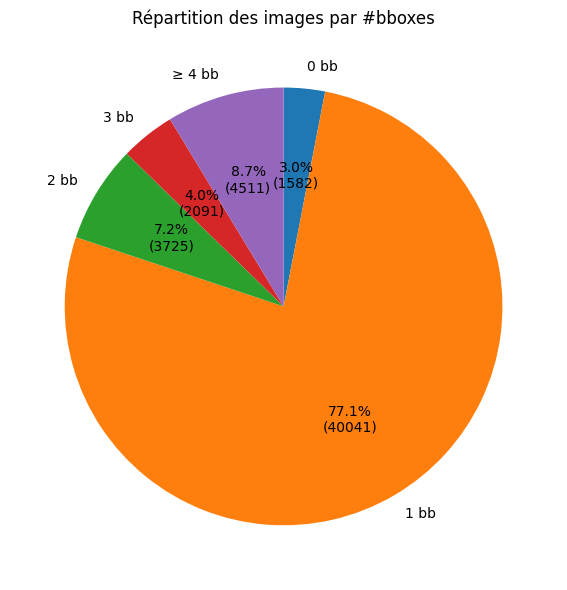

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_bbox_pie(max_bucket: int = 4, include_zero: bool = False, title: str = None):
    """
    Trace un camembert de la répartition du nombre de bounding boxes.
    - max_bucket = N : affiche des parts pour 1..(N-1) (et optionnellement 0), puis une part pour '≥ N'
    - include_zero : ajoute une part '0' si True
    """
    assert "bbox_count" in df.columns, "La DataFrame df doit contenir la colonne 'bbox_count'."
    assert max_bucket >= 1, "max_bucket doit être >= 1."

    counts = df["bbox_count"].value_counts()
    total = len(df)

    labels, sizes = [], []

    # 0 bb (optionnel)
    if include_zero:
        v0 = int(counts.get(0, 0))
        if v0 > 0:
            labels.append("0 bb")
            sizes.append(v0)

    # 1 .. (N-1)
    start_k = 1
    for k in range(start_k, max_bucket):
        v = int(counts.get(k, 0))
        if v > 0:
            labels.append(f"{k} bb")
            sizes.append(v)

    # Reste : ≥ N
    accounted = sum(sizes)
    remainder = total - accounted
    if remainder > 0:
        labels.append(f"≥ {max_bucket} bb")
        sizes.append(remainder)

    # Sécurité : si tout est dans une seule case (ex: que des ≥ N)
    if len(sizes) <= 1:
        print("⚠️ Répartition trop concentrée pour un camembert informatif. Affichage quand même.")
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct=lambda p: f"{p:.1f}%\n({int(round(p*total/100))})" if p > 0 else "",
        startangle=90,
        counterclock=False
    )
    plt.title(title or f"Répartition des images par #bboxes")
    plt.tight_layout()
    plt.show()

# Exemples d'usage :
# 1) Comme ton exemple : parts 1,2,3 puis '≥4'
plot_bbox_pie(max_bucket=4, include_zero=True)

# 2) Variante avec la part '0 bb' incluse : 0,1,2,3 puis '≥4'
# plot_bbox_pie(max_bucket=4, include_zero=True)

# Echantillonage de datamatrixmerged pour un dataset équilibré et qui reste représentatif

## Download dataset le plus récent de roboflow

In [32]:
from roboflow import Roboflow
rf = Roboflow(api_key="F1iDeTa9g7kP55ksutLk")
project = rf.workspace("industrial-qr").project("dmandqrdatasetsimple-v0kj6")
version = project.version(3)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dmandqrdatasetsimple-3 in yolov8:: 100%|██████████| 101948/101948 [00:17<00:00, 5980.59it/s]


In [34]:
from pathlib import Path
import pandas as pd
from collections import Counter

# === PARAMÈTRE : mets ici ton dossier d'images d'entrée ===
IMAGES_DIR =  Path("dmandqrdatasetsimple-3/train/images")   # ex.: "dmandqrdatasetsimple-3/train/images"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

assert IMAGES_DIR.exists(), f"Dossier introuvable: {IMAGES_DIR}"

def extract_prefix(filename: str) -> str:
    """
    Retourne le texte avant le premier underscore.
    Conserve la casse et les espaces (utile si tes préfixes contiennent des espaces).
    """
    stem = Path(filename).stem
    return stem.split("_", 1)[0] if "_" in stem else "UNKNOWN"

# 1) Scanner les images et compter les préfixes
prefix_counter = Counter()
total_imgs = 0

for p in IMAGES_DIR.iterdir():
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        total_imgs += 1
        prefix = extract_prefix(p.name)
        prefix_counter[prefix] += 1

# 2) Construire le tableau trié + pourcentages
df_counts = (
    pd.DataFrame(prefix_counter.items(), columns=["dataset_origin", "images"])
      .sort_values("images", ascending=False, ignore_index=True)
)
df_counts["percent"] = (df_counts["images"] / total_imgs * 100).round(2)

print(f"📦 Total images scannées : {total_imgs}\n")
display(df_counts)

# 3) Export CSV (optionnel)
out_csv = IMAGES_DIR.parent / "repartition_par_prefix.csv"
df_counts.to_csv(out_csv, index=False)
print(f"\n💾 Exporté : {out_csv}")

📦 Total images scannées : 50971



dataset_origin  images  percent
0    datamatrixmerged   40293    79.05
1            version2    2897     5.68
2               bcdmp    1788     3.51
3                  dm     966     1.90
4        2dDataMatrix     888     1.74
5                  2D     850     1.67
6                  Li     746     1.46
7                 asd     645     1.27
8            Detector     449     0.88
9          icecream-2     387     0.76
10                 2d     186     0.36
11               data     180     0.35
12       qrcodedetect     138     0.27
13                dmc     123     0.24
14  OR-Code-Detection     104     0.20
15                 DM      99     0.19
16              qrcut      92     0.18
17          codes2024      73     0.14
18                dpm      50     0.10
19                png      17     0.03


💾 Exporté : dmandqrdatasetsimple-3/train/repartition_par_prefix.csv


## Retirer les images de datamtrixmerged

In [33]:
from pathlib import Path
import shutil

# --- Réglages ---
SRC = Path("dmandqrdatasetsimple-3")      # dossier Roboflow source (avec train/valid/test)
DST = Path("balanced_dataset_datamatrixmerged_sampled")  # dossier de sortie
EXCLUDE_PREFIXES = ["datamatrixmerged"]    # insensible à la casse
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Recréation propre du dossier cible (mets à False si tu veux empêcher l’écrasement)
CLEAR_DST = True

# --- Préparation sortie ---
if CLEAR_DST and DST.exists():
    shutil.rmtree(DST)
(DST / "train/images").mkdir(parents=True, exist_ok=True)
(DST / "train/labels").mkdir(parents=True, exist_ok=True)
(DST / "valid/images").mkdir(parents=True, exist_ok=True)
(DST / "valid/labels").mkdir(parents=True, exist_ok=True)
(DST / "test/images").mkdir(parents=True, exist_ok=True)
(DST / "test/labels").mkdir(parents=True, exist_ok=True)

def is_excluded(stem: str) -> bool:
    s = stem.lower()
    return any(s.startswith(p.lower()) for p in EXCLUDE_PREFIXES)

def copy_split(split: str):
    src_img_dir = SRC / split / "images"
    src_lbl_dir = SRC / split / "labels"
    dst_img_dir = DST / split / "images"
    dst_lbl_dir = DST / split / "labels"

    kept_imgs = excluded_imgs = kept_lbls = 0

    if not src_img_dir.exists():
        print(f"⚠️  Split '{split}' introuvable (ignoré).")
        return (0,0,0,0)

    for img_path in src_img_dir.iterdir():
        if not img_path.is_file() or img_path.suffix.lower() not in IMG_EXTS:
            continue

        stem = img_path.stem
        if is_excluded(stem):
            excluded_imgs += 1
            continue  # on n’exporte ni l’image ni son label

        # copier l'image
        shutil.copy2(img_path, dst_img_dir / img_path.name)
        kept_imgs += 1

        # copier le label correspondant s'il existe
        lbl_src = src_lbl_dir / f"{stem}.txt"
        if lbl_src.exists():
            shutil.copy2(lbl_src, dst_lbl_dir / lbl_src.name)
            kept_lbls += 1

    # Compter les labels orphelins éventuellement copiés ? (non, on ne copie que si image gardée)
    return (kept_imgs, kept_lbls, excluded_imgs, 0)

totals = {"kept_imgs":0, "kept_lbls":0, "excluded_imgs":0}

for split in ["train", "valid", "test"]:
    ki, kl, ei, _ = copy_split(split)
    totals["kept_imgs"] += ki
    totals["kept_lbls"] += kl
    totals["excluded_imgs"] += ei
    print(f"[{split}] images gardées: {ki}, labels gardés: {kl}, images exclues: {ei}")

print("\n✅ Copie terminée.")
print(f"   Dossier source : {SRC.resolve()}")
print(f"   Dossier cible  : {DST.resolve()}")
print(f"   Total images gardées : {totals['kept_imgs']}")
print(f"   Total labels gardés  : {totals['kept_lbls']}")
print(f"   Total images exclues : {totals['excluded_imgs']}")

[train] images gardées: 10678, labels gardés: 10678, images exclues: 40293
⚠️  Split 'valid' introuvable (ignoré).
[valid] images gardées: 0, labels gardés: 0, images exclues: 0
⚠️  Split 'test' introuvable (ignoré).
[test] images gardées: 0, labels gardés: 0, images exclues: 0

✅ Copie terminée.
   Dossier source : /Users/benjaminmallefait/memoireQR/Thesis/dmandqrdatasetsimple-3
   Dossier cible  : /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_datamatrixmerged_sampled
   Total images gardées : 10678
   Total labels gardés  : 10678
   Total images exclues : 40293


## Ajouter les images selon les cluster fait précédemments dans cleaning.ipynb

Elle parcourt tes clusters dans datasets_clean/datamatrixmerged/grouped_images/, récupère les labels associés dans datasets_clean/datamatrixmerged/labels/, et construit une nouvelle sélection dans un dossier tampon daté (pour ne pas polluer ton dossier final si tu relances la cellule).

Règles appliquées
- cluster_-1 → on garde tout (images + labels).
- Images négatives (label absent ou vide) → on garde systématiquement (image + fichier label vide si besoin).
- Autres clusters → on échantillonne une part aléatoire d’images de taille ceil(p * N) (par défaut p=0.25), choix aléatoire des images.
- Pour chaque image sélectionnée, on copie son label s’il existe, sinon on crée un .txt vide (bon format YOLO).
- À la fin : compte total d’images gardées et combien sans bboxes.

In [41]:
import os
import shutil
import random
from pathlib import Path
from math import ceil
from datetime import datetime
from tqdm import tqdm

# === PARAMÈTRES ===
CLUSTERS_DIR = Path("datasets_clean/datamatrixmerged/grouped_images")
LABELS_DIR = Path("datasets_clean/datamatrixmerged/labels")
OUT_ROOT = Path("sampling_runs/sampled_datamatrixmerged")  # dossier de sortie unique
RATIO_KEEP = 0.1   # proportion à garder par cluster (si FIXED_PER_CLUSTER=None)
FIXED_PER_CLUSTER = None  # ex: 10 pour forcer 10 images max par cluster

NEG_PREFIX = "nobbox_"             # préfixe pour les images négatives
POS_PREFIX = "datamatrixmerged_"   # préfixe pour les images positives

# Nettoyage du dossier de sortie si déjà présent
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)
OUT_IMG = OUT_ROOT / "images"
OUT_LBL = OUT_ROOT / "labels"
OUT_IMG.mkdir(parents=True, exist_ok=True)
OUT_LBL.mkdir(parents=True, exist_ok=True)

def has_bbox(label_path: Path) -> bool:
    """Retourne True si le fichier label contient au moins 1 ligne."""
    return label_path.exists() and label_path.stat().st_size > 0

def copy_with_label(stem: str, src_img: Path, dst_img_dir: Path, dst_lbl_dir: Path, negative=False):
    """
    Copie l'image et son label (s'il existe).
    - Si negative=True → ajoute NEG_PREFIX
    - Sinon → ajoute POS_PREFIX
    """
    if negative:
        new_img_name = NEG_PREFIX + src_img.name
        new_lbl_name = NEG_PREFIX + f"{stem}.txt"
    else:
        new_img_name = POS_PREFIX + src_img.name
        new_lbl_name = POS_PREFIX + f"{stem}.txt"

    shutil.copy2(src_img, dst_img_dir / new_img_name)

    src_lbl = LABELS_DIR / f"{stem}.txt"
    dst_lbl = dst_lbl_dir / new_lbl_name
    if src_lbl.exists():
        shutil.copy2(src_lbl, dst_lbl)
    else:
        dst_lbl.touch()

total_kept = 0
total_negatives = 0

# Parcourir les clusters
for cluster_dir in sorted(CLUSTERS_DIR.iterdir()):
    if not cluster_dir.is_dir():
        continue

    cluster_name = cluster_dir.name
    images = list(cluster_dir.glob("*.*"))
    negatives = []
    positives = []

    # Séparer négatives et positives
    for img_path in images:
        stem = img_path.stem
        lbl_path = LABELS_DIR / f"{stem}.txt"
        if has_bbox(lbl_path):
            positives.append(img_path)
        else:
            negatives.append(img_path)

    kept_this_cluster = 0
    neg_kept_this_cluster = 0

    # Cas 1 : cluster_-1 → garder tout
    if cluster_name == "cluster_-1":
        for img_path in tqdm(images, desc=f"{cluster_name} (ALL)"):
            stem = img_path.stem
            negative = not has_bbox(LABELS_DIR / f"{stem}.txt")
            copy_with_label(stem, img_path, OUT_IMG, OUT_LBL, negative=negative)
            kept_this_cluster += 1
            if negative:
                neg_kept_this_cluster += 1

    # Cas 2 : garder tous les négatifs
    elif negatives:
        for img_path in tqdm(negatives, desc=f"{cluster_name} (NEGATIVES)"):
            stem = img_path.stem
            copy_with_label(stem, img_path, OUT_IMG, OUT_LBL, negative=True)
            kept_this_cluster += 1
            neg_kept_this_cluster += 1

    # Cas 3 : sélection au ratio ou au nombre fixe
    if positives:
        if FIXED_PER_CLUSTER is not None:
            n_keep = min(FIXED_PER_CLUSTER, len(positives))
        else:
            n_keep = ceil(len(positives) * RATIO_KEEP)
        selected = random.sample(positives, n_keep)

        for img_path in tqdm(selected, desc=f"{cluster_name} (POS SAMPLE)"):
            stem = img_path.stem
            copy_with_label(stem, img_path, OUT_IMG, OUT_LBL, negative=False)
            kept_this_cluster += 1

    total_kept += kept_this_cluster
    total_negatives += neg_kept_this_cluster

print(f"\n✅ Total images gardées : {total_kept}")
print(f"📉 Dont négatives : {total_negatives} ({total_negatives/total_kept*100:.2f}%)")
print(f"📂 Dossier final : {OUT_ROOT}")

cluster_999 (POS SAMPLE): 100%|██████████| 1/1 [00:00<00:00, 274.03it/s]


✅ Total images gardées : 13999
📉 Dont négatives : 1794 (12.82%)
📂 Dossier final : sampling_runs/sampled_datamatrixmerged


## Ajout du dossier sampled_datamatrixmerged dans balanced_dataset_datamatrix_sampled

In [43]:
import os
import shutil
from pathlib import Path

# --- Réglages ---
SRC = Path("sampling_runs/sampled_datamatrixmerged")  # contient images/ et labels/
DST = Path("balanced_dataset_datamatrixmerged_sampled")     # dataset cible
CLASS_NAMES = ["code"]  # <-- ajuste si plusieurs classes

# --- Vérifications source ---
SRC_IMG = SRC / "images"
SRC_LBL = SRC / "labels"
assert SRC_IMG.exists() and SRC_LBL.exists(), f"Source invalide: {SRC_IMG} / {SRC_LBL}"

# --- Prépare la cible (arbo YOLO) ---
for split in ["train", "valid", "test"]:
    (DST / split / "images").mkdir(parents=True, exist_ok=True)
    (DST / split / "labels").mkdir(parents=True, exist_ok=True)

DST_TRAIN_IMG = DST / "train" / "images"
DST_TRAIN_LBL = DST / "train" / "labels"

# --- Gestion des collisions de noms ---
def unique_name(dst_dir: Path, base_name: str) -> str:
    """
    Retourne un nom unique dans dst_dir en ajoutant _1, _2, ... si nécessaire.
    base_name inclut l'extension (ex: 'img123.jpg').
    """
    candidate = base_name
    stem = Path(base_name).stem
    ext = Path(base_name).suffix
    i = 1
    while (dst_dir / candidate).exists():
        candidate = f"{stem}_{i}{ext}"
        i += 1
    return candidate

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# --- Copie depuis SRC vers DST/train ---
copied_images = 0
copied_labels = 0
skipped = 0

for img_path in SRC_IMG.iterdir():
    if not img_path.is_file() or img_path.suffix.lower() not in IMG_EXTS:
        continue

    stem = img_path.stem
    lbl_src = SRC_LBL / f"{stem}.txt"

    # nom final (gérer collision côté images & labels)
    new_img_name = unique_name(DST_TRAIN_IMG, img_path.name)
    new_stem = Path(new_img_name).stem
    new_lbl_name = f"{new_stem}.txt"

    # copie image
    shutil.copy2(img_path, DST_TRAIN_IMG / new_img_name)
    copied_images += 1

    # copie label si présent, sinon label vide (conforme YOLO)
    if lbl_src.exists():
        shutil.copy2(lbl_src, DST_TRAIN_LBL / new_lbl_name)
        copied_labels += 1
    else:
        (DST_TRAIN_LBL / new_lbl_name).touch()

print(f"✅ Copie terminée vers: {DST_TRAIN_IMG.parent.parent.resolve()}")
print(f"   Images copiées: {copied_images}")
print(f"   Labels copiés : {copied_labels}")

# --- Génère data.yaml (YOLO) ---
data_yaml = f"""# Dataset YOLO pour entraînement local
path: {DST.as_posix()}
train: train/images
val: valid/images
test: test/images
nc: {len(CLASS_NAMES)}
names: {CLASS_NAMES}
"""

with open(DST / "data.yaml", "w", encoding="utf-8") as f:
    f.write(data_yaml)

print(f"📝 Fichier YOLO data.yaml écrit: {(DST / 'data.yaml').resolve()}")

# --- Génère roboflow.yaml (manifeste d’import informatif) ---
# Roboflow sait importer un dossier YOLO sans yaml ; on fournit ce yaml indicatif pour la documentation.
roboflow_yaml = f"""# Manifeste informatif pour import Roboflow (format YOLO)
# Import CLI suggéré :
#   roboflow import -w <workspace> -p <project> {DST.as_posix()}
dataset:
  name: balanced_dataset_datamatrix_sampled
  format: yolov8
  splits:
    train:
      images: train/images
      labels: train/labels
    valid:
      images: valid/images
      labels: valid/labels
    test:
      images: test/images
      labels: test/labels
  classes: {CLASS_NAMES}
"""

with open(DST / "roboflow.yaml", "w", encoding="utf-8") as f:
    f.write(roboflow_yaml)

print(f"📝 Fichier roboflow.yaml écrit: {(DST / 'roboflow.yaml').resolve()}")

# --- Rappel commande import Roboflow ---
print("\n➡️ Pour importer sur Roboflow (CLI):")
print(f"   roboflow import -w <workspace> -p <project> {DST.as_posix()}")

✅ Copie terminée vers: /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_datamatrixmerged_sampled
   Images copiées: 13248
   Labels copiés : 13248
📝 Fichier YOLO data.yaml écrit: /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_datamatrixmerged_sampled/data.yaml
📝 Fichier roboflow.yaml écrit: /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_datamatrixmerged_sampled/roboflow.yaml

➡️ Pour importer sur Roboflow (CLI):
   roboflow import -w <workspace> -p <project> balanced_dataset_datamatrixmerged_sampled


In [44]:
import os
from pathlib import Path
from PIL import Image
import shutil

# ========= Réglages =========
SRC = Path("balanced_dataset_datamatrixmerged_sampled")  # dataset d'entrée
DST = Path("balanced_dataset_datamatrixmerged_sampled_aabb_gray")  # dataset de sortie (séparé)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Nettoyer/Créer la sortie
if DST.exists():
    shutil.rmtree(DST)
DST.mkdir(parents=True, exist_ok=True)

# Détecter la structure (splits YOLO ou flat)
def detect_splits(root: Path):
    splits = []
    for s in ["train", "valid", "val", "test"]:
        if (root / s / "images").exists() and (root / s / "labels").exists():
            splits.append(s)
    if splits:
        return splits
    # fallback flat
    if (root / "images").exists() and (root / "labels").exists():
        return ["."]
    raise FileNotFoundError("Structure introuvable : ni splits YOLO (train/valid/test), ni flat images/labels.")

splits = detect_splits(SRC)

# Créer l'arbo dans DST
def ensure_out_dirs(dst_root: Path, split: str):
    if split == ".":
        (dst_root / "images").mkdir(parents=True, exist_ok=True)
        (dst_root / "labels").mkdir(parents=True, exist_ok=True)
        return dst_root / "images", dst_root / "labels"
    (dst_root / split / "images").mkdir(parents=True, exist_ok=True)
    (dst_root / split / "labels").mkdir(parents=True, exist_ok=True)
    return dst_root / split / "images", dst_root / split / "labels"

# ---- Helpers YOLO ----
def clip01(v):  # borne dans [0,1]
    return max(0.0, min(1.0, v))

def parse_line_to_aabb(tokens, img_w, img_h):
    """
    Prend une ligne YOLO (tokens: strings) et renvoie (xc,yc,w,h) normalisés + flag 'converted_from_poly'
    - Cas bbox: 5 tokens => class x y w h
    - Cas poly : >5 tokens => class x1 y1 x2 y2 ...
      -> calcule min/max et convertit en AABB
    Détecte si coords sont en pixels (>1) et normalise si besoin.
    """
    if len(tokens) < 5:
        return None, False  # ligne invalide

    # bboxes YOLO
    if len(tokens) == 5:
        try:
            x, y, w, h = map(float, tokens[1:5])
        except:
            return None, False
        # si c'est en pixels (rare en bbox), normaliser quand même
        if max(x, y, w, h) > 1.0:
            x /= img_w
            y /= img_h
            w /= img_w
            h /= img_h
        # clip
        x, y, w, h = clip01(x), clip01(y), clip01(w), clip01(h)
        return (x, y, w, h), False

    # segmentation YOLO -> AABB
    coords = tokens[1:]
    if len(coords) % 2 != 0:
        # nombre impair => invalide
        return None, False
    try:
        vals = list(map(float, coords))
    except:
        return None, False

    xs = vals[0::2]
    ys = vals[1::2]

    # détecter si pixels (si une coord >1)
    if max(xs + ys) > 1.0:
        xs = [x / img_w for x in xs]
        ys = [y / img_h for y in ys]

    xmin, xmax = max(0.0, min(xs)), min(1.0, max(xs))
    ymin, ymax = max(0.0, min(ys)), min(1.0, max(ys))
    w = max(0.0, xmax - xmin)
    h = max(0.0, ymax - ymin)
    if w == 0.0 or h == 0.0:
        return None, True  # AABB dégénérée -> on la jettera

    xc = clip01((xmin + xmax) / 2.0)
    yc = clip01((ymin + ymax) / 2.0)
    w, h = clip01(w), clip01(h)
    return (xc, yc, w, h), True

# ---- Traitement ----
images_processed = 0
labels_processed = 0
lines_bbox = 0
lines_poly_converted = 0
lines_invalid = 0
files_empty_after = 0

for split in splits:
    if split == ".":
        src_img_dir = SRC / "images"
        src_lbl_dir = SRC / "labels"
    else:
        src_img_dir = SRC / split / "images"
        src_lbl_dir = SRC / split / "labels"

    dst_img_dir, dst_lbl_dir = ensure_out_dirs(DST, split)

    # Parcours des images (et labels)
    for img_path in src_img_dir.iterdir():
        if not (img_path.is_file() and img_path.suffix.lower() in IMG_EXTS):
            continue

        stem = img_path.stem
        lbl_path = src_lbl_dir / f"{stem}.txt"
        dst_img_path = dst_img_dir / img_path.name
        dst_lbl_path = dst_lbl_dir / f"{stem}.txt"

        # 1) Ouvrir l'image, convertir en grayscale, sauvegarder
        try:
            with Image.open(img_path) as im:
                # conversion N&B
                gray = im.convert("L")
                gray.save(dst_img_path)
                img_w, img_h = gray.size
        except Exception as e:
            # si image illisible, on saute (et pas d'annotation)
            # (option: logger le nom)
            continue
        images_processed += 1

        # 2) Lire le label, convertir en AABB classe '0'
        aabbs = []
        if lbl_path.exists():
            try:
                with open(lbl_path, "r", encoding="utf-8") as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        tokens = line.split()
                        result = parse_line_to_aabb(tokens, img_w, img_h)
                        if result is None:
                            lines_invalid += 1
                            continue
                        box, was_poly = result
                        if box is None:
                            lines_invalid += 1
                            continue
                        x, y, w, h = box
                        # rejeter AABB vide
                        if w <= 0.0 or h <= 0.0:
                            lines_invalid += 1
                            continue
                        aabbs.append((x, y, w, h))
                        if was_poly:
                            lines_poly_converted += 1
                        else:
                            lines_bbox += 1
            except Exception:
                # pb de lecture -> ignorer
                pass

        # 3) Écrire le label (classe 0 pour toutes les bboxes)
        with open(dst_lbl_path, "w", encoding="utf-8") as out:
            for (x, y, w, h) in aabbs:
                out.write(f"0 {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        labels_processed += 1
        if len(aabbs) == 0:
            files_empty_after += 1

# ---- Résumé ----
print("✅ Conversion terminée")
print(f"• Images converties en niveaux de gris : {images_processed}")
print(f"• Fichiers label traités              : {labels_processed}")
print(f"• Lignes bbox conservées (classe→0)   : {lines_bbox}")
print(f"• Lignes polygonales → AABB converties: {lines_poly_converted}")
print(f"• Lignes invalides rejetées           : {lines_invalid}")
print(f"• Labels vides après conversion       : {files_empty_after}")
print(f"📂 Dataset de sortie : {DST.resolve()}")

✅ Conversion terminée
• Images converties en niveaux de gris : 23926
• Fichiers label traités              : 23926
• Lignes bbox conservées (classe→0)   : 35135
• Lignes polygonales → AABB converties: 14183
• Lignes invalides rejetées           : 0
• Labels vides après conversion       : 1848
📂 Dataset de sortie : /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_datamatrixmerged_sampled_aabb_gray


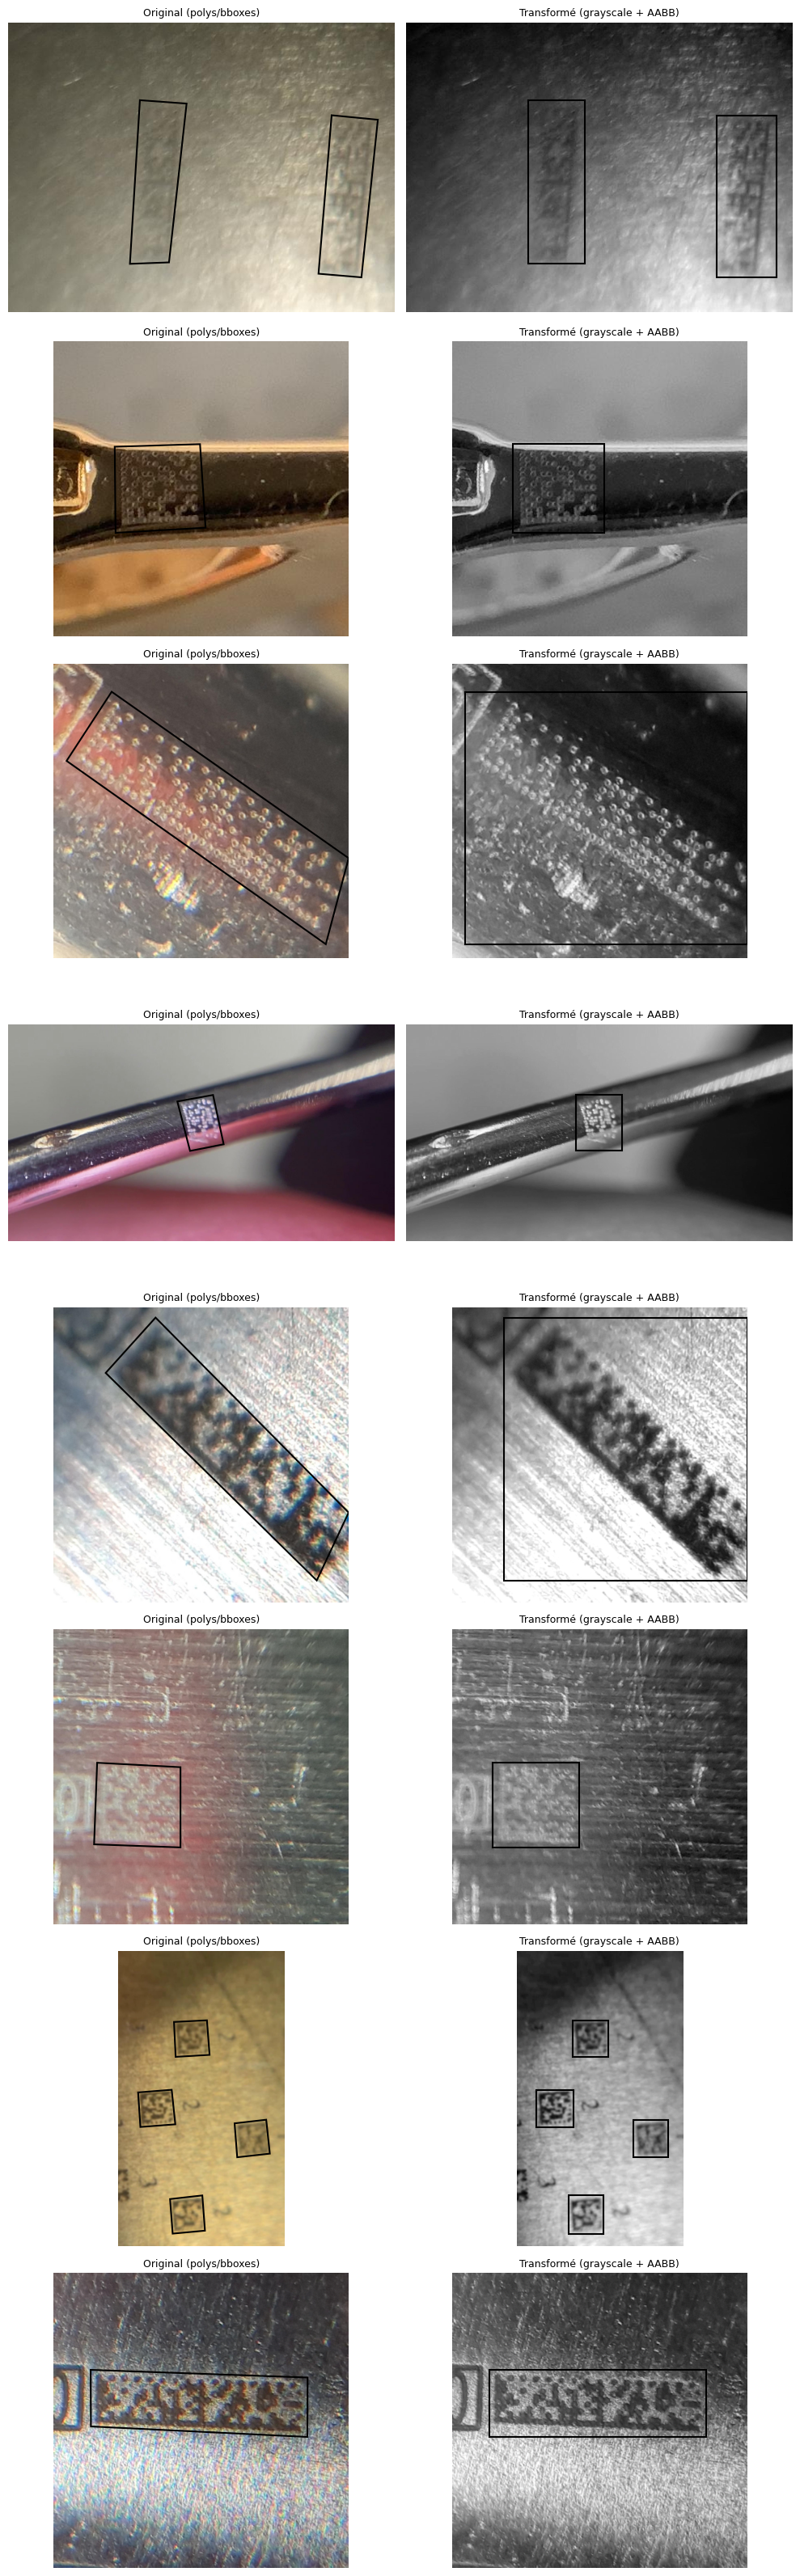

Affichées: 8 paires (original vs transformé).


In [46]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

# =========================
# Réglages
# =========================
SRC_ROOT = Path("balanced_dataset_datamatrixmerged_sampled")        # dataset original (polygones possibles)
DST_ROOT = Path("balanced_dataset_datamatrixmerged_sampled_aabb_gray")  # dataset transformé (grayscale + AABB)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
MAX_SAMPLES = 8   # nombre de paires à afficher (images avec polygones)

# =========================
# Utilitaires
# =========================
def detect_splits(root: Path):
    """Renvoie la liste des splits présents (train/valid/test), sinon '.' pour structure flat."""
    splits = []
    for s in ["train", "valid", "val", "test"]:
        if (root / s / "images").exists() and (root / s / "labels").exists():
            splits.append(s)
    if splits:
        return splits
    if (root / "images").exists() and (root / "labels").exists():
        return ["."]
    raise FileNotFoundError(f"Aucune structure YOLO détectée dans {root}.")

def list_images(dir_path: Path):
    return [p for p in dir_path.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]

def yolo_line_is_polygon(tokens):
    """True si la ligne YOLO ressemble à une segmentation (nb tokens > 5 et pair après la classe)."""
    return len(tokens) > 5 and (len(tokens) - 1) % 2 == 0

def parse_yolo_line(tokens, img_w, img_h):
    """
    Parse une ligne YOLO.
    Retourne dict:
      { 'type': 'bbox', 'bbox': (xc,yc,w,h) }  (normalisés 0..1)
      ou
      { 'type': 'poly', 'poly': [(x,y), ...] } (normalisés 0..1)
    Si coords >1, on suppose pixels et on normalise.
    """
    if len(tokens) < 5:
        return None
    # BBox YOLO
    if len(tokens) == 5:
        try:
            x, y, w, h = map(float, tokens[1:5])
        except:
            return None
        if max(x, y, w, h) > 1.0:
            x /= img_w; y /= img_h; w /= img_w; h /= img_h
        return {'type': 'bbox', 'bbox': (x, y, w, h)}
    # Segmentation
    coords = tokens[1:]
    if len(coords) % 2 != 0:
        return None
    try:
        vals = list(map(float, coords))
    except:
        return None
    xs = vals[0::2]
    ys = vals[1::2]
    if max(xs + ys) > 1.0:
        xs = [x / img_w for x in xs]
        ys = [y / img_h for y in ys]
    pts = list(zip(xs, ys))
    return {'type': 'poly', 'poly': pts}

def load_annotations(label_path: Path, img_size):
    """Charge toutes les annotations YOLO d'un fichier."""
    ann = []
    if not label_path.exists():
        return ann
    w, h = img_size
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            t = line.strip().split()
            if not t:
                continue
            parsed = parse_yolo_line(t, w, h)
            if parsed is not None:
                ann.append(parsed)
    return ann

def any_polygon_in_label(label_path: Path, img_size):
    """True si le label contient au moins une polyline/polygon YOLO."""
    if not label_path.exists():
        return False
    w, h = img_size
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            t = line.strip().split()
            if not t:
                continue
            if yolo_line_is_polygon(t):
                return True
    return False

def to_pixel_bbox(xc, yc, w, h, img_w, img_h):
    """Convertit bbox normalisée (xc,yc,w,h) en pixels (x0,y0, W, H)."""
    X = xc * img_w; Y = yc * img_h
    W = w * img_w;  H = h * img_h
    x0 = X - W/2; y0 = Y - H/2
    return x0, y0, W, H

def to_pixel_poly(pts, img_w, img_h):
    """Convertit points normalisés en pixels."""
    return [(x*img_w, y*img_h) for (x,y) in pts]

def draw_original(ax, img, annotations):
    """Dessine polygones (rouge) et bboxes (jaune) sur l'image originale."""
    ax.imshow(img)
    ax.axis('off')
    img_w, img_h = img.size
    for a in annotations:
        if a['type'] == 'poly':
            poly = to_pixel_poly(a['poly'], img_w, img_h)
            ax.add_patch(Polygon(poly, fill=False, linewidth=1.5))
        elif a['type'] == 'bbox':
            x, y, w, h = to_pixel_bbox(*a['bbox'], img_w, img_h)
            ax.add_patch(Rectangle((x, y), w, h, fill=False, linewidth=1.5))
    ax.set_title("Original (polys/bboxes)", fontsize=9)

def draw_transformed(ax, img, annotations):
    """Dessine uniquement des AABB (vert) sur l'image transformée (grayscale)."""
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    img_w, img_h = img.size
    for a in annotations:
        if a['type'] == 'bbox':
            x, y, w, h = to_pixel_bbox(*a['bbox'], img_w, img_h)
            ax.add_patch(Rectangle((x, y), w, h, fill=False, linewidth=1.5))
    ax.set_title("Transformé (grayscale + AABB)", fontsize=9)

# =========================
# Recherche d'échantillons
# =========================
src_splits = detect_splits(SRC_ROOT)
dst_splits = detect_splits(DST_ROOT)
# on suppose mêmes splits (ou '.' de part et d'autre)
assert set(src_splits) == set(dst_splits), f"Splits différents entre {SRC_ROOT} et {DST_ROOT}"

pairs = []  # (src_img_path, src_lbl_path, dst_img_path, dst_lbl_path)

for split in src_splits:
    if split == ".":
        s_img_dir = SRC_ROOT / "images"
        s_lbl_dir = SRC_ROOT / "labels"
        d_img_dir = DST_ROOT / "images"
        d_lbl_dir = DST_ROOT / "labels"
    else:
        s_img_dir = SRC_ROOT / split / "images"
        s_lbl_dir = SRC_ROOT / split / "labels"
        d_img_dir = DST_ROOT / split / "images"
        d_lbl_dir = DST_ROOT / split / "labels"

    for img_path in list_images(s_img_dir):
        stem = img_path.stem
        src_lbl = s_lbl_dir / f"{stem}.txt"
        dst_img = d_img_dir / img_path.name
        dst_lbl = d_lbl_dir / f"{stem}.txt"
        if not (dst_img.exists() and dst_lbl.exists()):
            continue
        # On ne retient que les images dont l'annotation source contient AU MOINS un polygone
        try:
            with Image.open(img_path) as im:
                if any_polygon_in_label(src_lbl, im.size):
                    pairs.append((img_path, src_lbl, dst_img, dst_lbl))
        except Exception:
            continue

# Limiter aux MAX_SAMPLES premiers
pairs = pairs[:MAX_SAMPLES]

if not pairs:
    print("Aucune image avec annotation polygonale trouvée (vérifie SRC_ROOT).")
else:
    # =========================
    # Affichage
    # =========================
    rows = len(pairs)
    plt.figure(figsize=(10, 4 * rows))

    for i, (src_img_p, src_lbl_p, dst_img_p, dst_lbl_p) in enumerate(pairs):
        # Chargement images
        src_img = Image.open(src_img_p).convert("RGB")
        dst_img = Image.open(dst_img_p)  # déjà grayscale

        # Annotations
        ann_src = load_annotations(src_lbl_p, src_img.size)
        ann_dst = load_annotations(dst_lbl_p, dst_img.size)

        # Original (gauche)
        ax1 = plt.subplot(rows, 2, 2*i + 1)
        draw_original(ax1, src_img, ann_src)
        ax1.set_xlabel(src_img_p.name, fontsize=8)

        # Transformé (droite)
        ax2 = plt.subplot(rows, 2, 2*i + 2)
        draw_transformed(ax2, dst_img, ann_dst)
        ax2.set_xlabel(dst_img_p.name, fontsize=8)

    plt.tight_layout()
    plt.show()
    print(f"Affichées: {len(pairs)} paires (original vs transformé).")

# split équilibré du dataset

In [1]:
import os
import random
import math
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
from tqdm import tqdm

# ======================
# Paramètres principaux
# ======================
SRC_ROOT = Path("dmandqrdatasetsimple-3")  # dataset source (actuellement tout dans train/)
SRC_IMG_DIR = SRC_ROOT / "train" / "images"
SRC_LBL_DIR = SRC_ROOT / "train" / "labels"

OUT_ROOT = Path("balanced_dataset_full_splits")
RATIOS = {"train": 0.75, "valid": 0.15, "test": 0.1}
SEED = 42
COPY_FILES = True  # False => déplace (move)

# Binning de la densité de bboxes
def bbox_bin(n):
    if n == 0:   return "0"
    if n == 1:   return "1"
    if 2 <= n <= 3:  return "2-3"
    if 4 <= n <= 8:  return "4-8"
    return "9+"

# Extraction du dataset d'origine (préfixe avant le 1er underscore)
def dataset_origin_from_name(name_stem: str) -> str:
    return name_stem.split("_", 1)[0] if "_" in name_stem else "UNKNOWN"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

assert SRC_IMG_DIR.exists() and SRC_LBL_DIR.exists(), "Dossiers source introuvables."

random.seed(SEED)

# ============
# Scan source
# ============
records = []
img_paths = [p for p in SRC_IMG_DIR.iterdir() if p.suffix.lower() in IMG_EXTS]

def count_bboxes(lbl_path: Path) -> int:
    if not lbl_path.exists():
        return 0
    n = 0
    with open(lbl_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                n += 1
    return n

for img_p in tqdm(img_paths, desc="Scan"):
    stem = img_p.stem
    lbl_p = SRC_LBL_DIR / f"{stem}.txt"
    nbb = count_bboxes(lbl_p)
    rec = {
        "stem": stem,
        "image": img_p,
        "label": lbl_p if lbl_p.exists() else None,
        "dataset_origin": dataset_origin_from_name(stem),
        "bbox_count": nbb,
        "neg": (nbb == 0),
        "bin": bbox_bin(nbb)
    }
    records.append(rec)

df = pd.DataFrame(records)
total_images = len(df)
assert total_images > 0, "Aucune image trouvée."

print(f"Total images: {total_images}")
print("Répartition initiale par dataset_origin (top 10) :")
display(df["dataset_origin"].value_counts().head(10))

# ==========================
# Stratification multi-crit
# ==========================
# Clé de stratification : origine × bin (la case '0' représente les négatifs)
df["strat_key"] = df["dataset_origin"] + "||" + df["bin"]

# Fonction de split par groupe
def split_indices(indices, ratios=RATIOS):
    idx = indices[:]  # copie
    random.shuffle(idx)
    n = len(idx)
    n_train = max(0, math.floor(ratios["train"] * n))
    n_valid = max(0, math.floor(ratios["valid"] * n))
    # le reste va au test (assure somme)
    n_test = n - n_train - n_valid
    # ajustements si arrondis font 0 alors que n>=1
    if n >= 1 and (n_train + n_valid + n_test) == 0:
        n_train = 1
    return {
        "train": idx[:n_train],
        "valid": idx[n_train:n_train+n_valid],
        "test":  idx[n_train+n_valid:]
    }

# Appliquer le split groupe par groupe
assign = {}
assign["train"], assign["valid"], assign["test"] = set(), set(), set()

for key, sub in df.groupby("strat_key"):
    idxs = sub.index.tolist()
    out = split_indices(idxs, RATIOS)
    for split in ["train", "valid", "test"]:
        assign[split].update(out[split])

# Vérif pas de chevauchement
assert assign["train"].isdisjoint(assign["valid"])
assert assign["train"].isdisjoint(assign["test"])
assert assign["valid"].isdisjoint(assign["test"])

df["split"] = None
for split in ["train", "valid", "test"]:
    df.loc[df.index.isin(assign[split]), "split"] = split

# ==========================
# Création arbo & copie
# ==========================
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)

for split in ["train", "valid", "test"]:
    (OUT_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (OUT_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

def do_copy_or_move(src: Path, dst: Path):
    if COPY_FILES:
        shutil.copy2(src, dst)
    else:
        shutil.move(src, dst)

copied = {"train":0, "valid":0, "test":0}
for _, row in tqdm(df.iterrows(), total=len(df), desc="Écriture"):
    split = row["split"]
    img_src: Path = row["image"]
    lbl_src: Path = row["label"]
    img_dst = OUT_ROOT / split / "images" / img_src.name
    lbl_dst = OUT_ROOT / split / "labels" / f"{img_src.stem}.txt"

    do_copy_or_move(img_src, img_dst)
    if lbl_src and lbl_src.exists():
        do_copy_or_move(lbl_src, lbl_dst)
    else:
        # crée un label vide pour rester YOLO‑conforme
        lbl_dst.touch()
    copied[split] += 1

print("Copie terminée :", copied)

# ==========================
# Récap lisible
# ==========================
def recap(df_split):
    total = len(df_split)
    neg_rate = (df_split["neg"].mean() * 100) if total else 0.0
    by_origin = df_split["dataset_origin"].value_counts(normalize=True).mul(100).round(2)
    by_bin = df_split["bin"].value_counts(normalize=True).mul(100).round(2)
    return total, neg_rate, by_origin, by_bin

for split in ["train", "valid", "test"]:
    sub = df[df["split"] == split]
    total, neg_rate, by_origin, by_bin = recap(sub)
    print(f"\n=== {split.upper()} ===")
    print(f"Images: {total} | % négatives: {neg_rate:.2f}%")
    print("Répartition par dataset_origin (top 8):")
    display(by_origin.head(8))
    print("Répartition par bin de bboxes:")
    display(by_bin.sort_index())

# ==========================
# data.yaml pour YOLO
# ==========================
data_yaml = f"""# Dataset YOLO (split stratifié)
path: {OUT_ROOT.as_posix()}
train: train/images
val: valid/images
test: test/images
nc: 1
names: ["code"]
"""
with open(OUT_ROOT / "data.yaml", "w", encoding="utf-8") as f:
    f.write(data_yaml)
print(f"\n📝 data.yaml écrit → {(OUT_ROOT / 'data.yaml').resolve()}")

Scan: 100%|██████████| 50971/50971 [00:08<00:00, 5934.03it/s]

Total images: 50971
Répartition initiale par dataset_origin (top 10) :


datamatrixmerged    40293
version2             2897
bcdmp                1788
dm                    966
2dDataMatrix          888
2D                    850
Li                    746
asd                   645
Detector              449
icecream-2            387
Name: dataset_origin, dtype: int64

Écriture: 100%|██████████| 50971/50971 [00:46<00:00, 1094.91it/s]

Copie terminée : {'train': 38211, 'valid': 7623, 'test': 5137}

=== TRAIN ===
Images: 38211 | % négatives: 3.05%
Répartition par dataset_origin (top 8):


datamatrixmerged    79.08
version2             5.68
bcdmp                3.50
dm                   1.89
2dDataMatrix         1.74
2D                   1.67
Li                   1.46
asd                  1.26
Name: dataset_origin, dtype: float64

Répartition par bin de bboxes:


0       3.05
1      76.72
2-3    11.40
4-8     7.45
9+      1.38
Name: bin, dtype: float64


=== VALID ===
Images: 7623 | % négatives: 3.04%
Répartition par dataset_origin (top 8):


datamatrixmerged    79.26
version2             5.67
bcdmp                3.50
dm                   1.88
2dDataMatrix         1.73
2D                   1.67
Li                   1.46
asd                  1.25
Name: dataset_origin, dtype: float64

Répartition par bin de bboxes:


0       3.04
1      76.81
2-3    11.36
4-8     7.44
9+      1.35
Name: bin, dtype: float64


=== TEST ===
Images: 5137 | % négatives: 3.08%
Répartition par dataset_origin (top 8):


datamatrixmerged    78.49
version2             5.72
bcdmp                3.54
dm                   1.95
2dDataMatrix         1.77
2D                   1.67
Li                   1.48
asd                  1.30
Name: dataset_origin, dtype: float64

Répartition par bin de bboxes:


0       3.08
1      76.33
2-3    11.54
4-8     7.57
9+      1.48
Name: bin, dtype: float64


📝 data.yaml écrit → /Users/benjaminmallefait/memoireQR/Thesis/balanced_dataset_full_splits/data.yaml


# Refaire les extensions et les noms de fichier.


In [28]:
ROOT = Path("balanced_dataset_full_splits")   # <-- ton dataset


In [29]:
from pathlib import Path
from collections import defaultdict, Counter

# ========= CONFIG =========
IMG_DIR = "images"
LBL_DIR = "labels"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".JPG", ".PNG", ".JPEG", ".WEBP"}
LBL_EXTS = {".txt"}  # YOLO labels

MIN_COUNT = 1            # filtre d'affichage (p.ex. 3 ou 5 si tu veux masquer le bruit)
EXAMPLES_PER_PREFIX = 2  # combien d'exemples à montrer par préfixe

# ========= COLLECTE FICHIERS (avec ou sans splits) =========
def collect_paths(root: Path):
    paths = []
    possible_splits = ["train", "valid", "test"]
    has_split = any((root / sp / IMG_DIR).exists() or (root / sp / LBL_DIR).exists()
                    for sp in possible_splits)
    if has_split:
        for sp in possible_splits:
            for sub in (IMG_DIR, LBL_DIR):
                d = root / sp / sub
                if d.exists():
                    paths.extend([p for p in d.iterdir() if p.is_file()])
    else:
        for sub in (IMG_DIR, LBL_DIR):
            d = root / sub
            if d.exists():
                paths.extend([p for p in d.iterdir() if p.is_file()])
    return [p for p in paths if (p.suffix in IMG_EXTS or p.suffix in LBL_EXTS)]

files = collect_paths(ROOT)
if not files:
    raise SystemExit(f"Aucun fichier image/label trouvé sous {ROOT}")

# ========= GÉNÉRATION DES CANDIDATS PAR FICHIER =========
def underscore_positions(stem: str):
    return [i for i, ch in enumerate(stem) if ch == "_"]

file_candidates = {}               # stem -> liste des candidats (préfixes possibles)
candidate_global_counts = Counter()

for p in files:
    stem = p.stem
    pos_list = underscore_positions(stem)
    if not pos_list:
        # pas de '_' -> pas de candidat pour ce fichier (on ignore)
        continue
    cands = [stem[:pos] for pos in pos_list]   # toutes les coupures possibles
    file_candidates[stem] = cands
    # compte global des candidats (toutes origines confondues)
    candidate_global_counts.update(set(cands))  # set() pour ne pas surcompter le même cand sur un même fichier

# ========= SÉLECTION DU MEILLEUR PRÉFIXE PAR FICHIER =========
# critère : fréquence globale max, puis longueur max
chosen_by_file = {}
for stem, cands in file_candidates.items():
    best = max(cands, key=lambda c: (candidate_global_counts[c], len(c)))
    chosen_by_file[stem] = best

# agrégation finale
final_counts = Counter(chosen_by_file.values())
# exemples par préfixe
examples = defaultdict(list)
for p in files:
    stem = p.stem
    pref = chosen_by_file.get(stem)
    if pref and len(examples[pref]) < EXAMPLES_PER_PREFIX:
        examples[pref].append(p.name)

# ========= AFFICHAGE =========
print(f"Fichiers analysés : {len(files)}")
print(f"Fichiers avec '_' : {len(file_candidates)}")
print("\nPréfixes détectés (triés par fréquence) :")
detected = [(pref, cnt) for pref, cnt in final_counts.most_common() if cnt >= MIN_COUNT]
print(f"Total préfixes : {len(detected)} (seuil MIN_COUNT={MIN_COUNT})\n")

for pref, cnt in detected:
    print(f"- {pref}  (x{cnt})")
    for ex in examples[pref]:
        print(f"    • {ex}")

Fichiers analysés : 101942
Fichiers avec '_' : 50971

Préfixes détectés (triés par fréquence) :
Total préfixes : 20 (seuil MIN_COUNT=1)

- datamatrixmerged  (x40293)
    • datamatrixmerged_4347_jpg.rf.ea583e3fd31791223d97941db6f1824a.jpg
    • datamatrixmerged_14298_jpg.rf.01a178d170d20f299891ead056c5e2f7.jpg
- version2_0opxu_b3qwo  (x2897)
    • version2_0opxu_b3qwo_version2-2308-_jpg.rf.4855cb12c408dac8ef000e9262f5c348.jpg
    • version2_0opxu_b3qwo_version2-256-_jpg.rf.bd41407b32769d64c6f9069acf8b181d.jpg
- bcdmp_bnhpr  (x1788)
    • bcdmp_bnhpr_image6_fov40_jpg.rf.9022e1ef25707792f7d4d1db417e7945.jpg
    • bcdmp_bnhpr_Image329_jpg.rf.b674a262f83122beb7bf498a16bbe301.jpg
- dm_milk_v4  (x966)
    • dm_milk_v4_Test1_000000048_220428_173207_935_jpg.rf.0e7ad13500b18de6ef555811dcb153a1.jpg
    • dm_milk_v4_Test1_000000111_220428_154143_486_jpg.rf.130c7ec86e417fae538eec484e8b9453.jpg
- 2dDataMatrix  (x888)
    • 2dDataMatrix_e5b14d3b-8387-45c1-af10-8c2b395a9b5e_png.rf.1ab612a390554248fa19

In [30]:
from pathlib import Path
from collections import defaultdict, Counter
import re

# ========= PARAMÈTRES =========
IMG_DIR = "images"
LBL_DIR = "labels"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".JPG", ".PNG", ".JPEG", ".WEBP"}
LBL_EXTS = {".txt"}  # YOLO labels

# DO_RENAME = True           # False = aperçu seulement ; True = renomme réellement
DO_RENAME = True           # False = aperçu seulement ; True = renomme réellement
PREVIEW_PER_PREFIX = 6      # nb d'exemples max à afficher par préfixe
MIN_COUNT = 1               # filtre d'affichage (garde les préfixes détectés au moins N fois)

# ========= FONCTIONS UTILITAIRES =========
def collect_paths(root: Path):
    """Retourne tous les chemins (images + labels), avec et sans splits train/val/test."""
    paths = []
    possible_splits = ["train", "valid", "test"]
    has_split = any((root / sp / IMG_DIR).exists() or (root / sp / LBL_DIR).exists()
                    for sp in possible_splits)
    if has_split:
        for sp in possible_splits:
            for sub in (IMG_DIR, LBL_DIR):
                d = root / sp / sub
                if d.exists():
                    paths.extend([p for p in d.iterdir() if p.is_file()])
    else:
        for sub in (IMG_DIR, LBL_DIR):
            d = root / sub
            if d.exists():
                paths.extend([p for p in d.iterdir() if p.is_file()])
    return [p for p in paths if (p.suffix in IMG_EXTS or p.suffix in LBL_EXTS)]

def underscore_positions(stem: str):
    """Indices des '_' dans le stem."""
    return [i for i, ch in enumerate(stem) if ch == "_"]

def best_prefix_choice(stem: str, global_counts: Counter):
    """
    Pour un stem donné, retourne:
      - chosen_prefix (partie avant '_' choisie),
      - split_pos (index du '_' retenu),
      - remainder (la partie APRÈS ce '_' – sans le '_').
    Choix = candidat de fréquence globale max, puis le plus long.
    """
    positions = underscore_positions(stem)
    if not positions:
        return None, None, None
    candidates = [(stem[:pos], pos) for pos in positions]
    # Note: on ne recompte pas plusieurs fois le même candidat pour ce fichier
    best_cand, best_pos = max(candidates, key=lambda c: (global_counts[c[0]], len(c[0])))
    remainder = stem[best_pos+1:]  # après l'underscore retenu
    return best_cand, best_pos, remainder

def clean_prefix(prefix: str) -> str:
    """Supprime tout ce qui n'est pas alphanumérique, puis ajoute '_' (unique) à la fin."""
    cleaned = re.sub(r"[^A-Za-z0-9]", "", prefix)
    return cleaned + "_" if cleaned else ""  # si préfixe vide après nettoyage, on laissera le nom inchangé

def ensure_unique_path(dst: Path) -> Path:
    """Évite collisions en ajoutant __dupN avant l'extension si nécessaire."""
    if not dst.exists():
        return dst
    stem, suf, parent = dst.stem, dst.suffix, dst.parent
    n = 1
    while True:
        cand = parent / f"{stem}__dup{n}{suf}"
        if not cand.exists():
            return cand
        n += 1

# ========= DÉTECTION DES CANDIDATS (comme dans la 1ère cellule) =========
files = collect_paths(ROOT)
if not files:
    raise SystemExit(f"Aucun fichier image/label trouvé sous {ROOT}")

# Étape 1: générer toutes les coupures possibles et compter globalement les candidats de préfixe
candidate_global_counts = Counter()
file_positions = {}  # stem -> liste d'indices '_' (pour éviter de recalculer)
for p in files:
    stem = p.stem
    pos_list = underscore_positions(stem)
    file_positions[stem] = pos_list
    if not pos_list:
        continue
    # on compte chaque candidat unique au plus une fois par fichier
    candidates = {stem[:pos] for pos in pos_list}
    candidate_global_counts.update(candidates)

# Étape 2: choisir le meilleur préfixe pour chaque fichier
chosen = {}  # stem -> (prefix, split_pos, remainder)
for p in files:
    stem = p.stem
    if not file_positions.get(stem):
        continue
    pref, pos, rem = best_prefix_choice(stem, candidate_global_counts)
    chosen[stem] = (pref, pos, rem)

# ========= CONSTRUCTION DES RENOMMAGES =========
renames = []                  # tuples: (old_path, new_path, old_name, new_name, old_prefix, new_prefix)
preview_by_prefix = defaultdict(list)
counts_by_prefix = Counter()
unchanged = 0

for p in files:
    stem = p.stem
    ext = p.suffix
    if stem not in chosen:
        # pas de '_' -> inchangé
        unchanged += 1
        continue

    picked_prefix, split_pos, remainder = chosen[stem]
    new_prefix = clean_prefix(picked_prefix)  # => alnum + '_'
    if not new_prefix:
        # préfixe devenu vide après nettoyage -> on n'applique pas
        unchanged += 1
        continue

    # Nouveau stem = NEWPREFIX + remainder (sans l'underscore de split)
    new_stem = new_prefix + remainder
    new_name = new_stem + ext
    if new_name == p.name:
        unchanged += 1
        continue

    new_path = ensure_unique_path(p.with_name(new_name))
    renames.append((p, new_path, p.name, new_name, picked_prefix, new_prefix))
    counts_by_prefix[(picked_prefix, new_prefix)] += 1
    if len(preview_by_prefix[(picked_prefix, new_prefix)]) < PREVIEW_PER_PREFIX:
        preview_by_prefix[(picked_prefix, new_prefix)].append((p.name, new_name))

# ========= APERÇU =========
total = len(files)
print(f"Fichiers scannés         : {total}")
print(f"Sans '_' (inchangés)     : {unchanged}")
print(f"À renommer (proposés)    : {len(renames)}")
print(f"Préfixes détectés (>= {MIN_COUNT}) : {sum(1 for k,v in counts_by_prefix.items() if v >= MIN_COUNT)}\n")

print("=== APERÇU AVANT → APRÈS (par préfixe détecté) ===")
if not counts_by_prefix:
    print("(aucune proposition de renommage)")
else:
    # tri par fréquence décroissante
    for (old_pref, new_pref), cnt in sorted(counts_by_prefix.items(), key=lambda kv: kv[1], reverse=True):
        if cnt < MIN_COUNT:
            continue
        print(f"\n[{old_pref!r}  ->  {new_pref!r}]  x{cnt}")
        for before, after in preview_by_prefix[(old_pref, new_pref)]:
            print(f"  {before}  ->  {after}")

print("\nMode renommage effectif :", DO_RENAME)

# ========= RENOMMAGE EFFECTIF (optionnel) =========
if DO_RENAME and renames:
    for old_p, new_p, old_n, new_n, old_pref, new_pref in renames:
        # Crée le dossier au besoin (utile si tu mixes splits / racine)
        new_p.parent.mkdir(parents=True, exist_ok=True)
        old_p.rename(new_p)
    print(f"\n✅ Renommage effectué : {len(renames)} fichiers renommés.")
elif not DO_RENAME:
    print("💡 Dry-run : aucun fichier n'a été modifié.")

Fichiers scannés         : 101942
Sans '_' (inchangés)     : 84550
À renommer (proposés)    : 17392
Préfixes détectés (>= 1) : 16

=== APERÇU AVANT → APRÈS (par préfixe détecté) ===

['version2_0opxu_b3qwo'  ->  'version20opxub3qwo_']  x5794
  version2_0opxu_b3qwo_version2-2308-_jpg.rf.4855cb12c408dac8ef000e9262f5c348.jpg  ->  version20opxub3qwo_version2-2308-_jpg.rf.4855cb12c408dac8ef000e9262f5c348.jpg
  version2_0opxu_b3qwo_version2-256-_jpg.rf.bd41407b32769d64c6f9069acf8b181d.jpg  ->  version20opxub3qwo_version2-256-_jpg.rf.bd41407b32769d64c6f9069acf8b181d.jpg
  version2_0opxu_b3qwo_version2-1434-_jpg.rf.ca3626a97c3c3fa380d14171feb30c1e.jpg  ->  version20opxub3qwo_version2-1434-_jpg.rf.ca3626a97c3c3fa380d14171feb30c1e.jpg
  version2_0opxu_b3qwo_version2-1977-_jpg.rf.e4bd9d1b68f3da2ca3ff3a1a7d106780.jpg  ->  version20opxub3qwo_version2-1977-_jpg.rf.e4bd9d1b68f3da2ca3ff3a1a7d106780.jpg
  version2_0opxu_b3qwo_version2-1478-_jpg.rf.3255e5a8b0f28dafd7c55194e9ccd4be.jpg  ->  version20opxu

In [4]:
from pathlib import Path
import shutil
from tqdm import tqdm

def merge_dataset_to_cleaned_merged(dataset_path: str, output_base: str = "../assembled_cleaned_merged"):
    dataset_path = Path(dataset_path)
    dataset_name = dataset_path.stem

    # Dossiers de sortie
    output_img_dir = Path(output_base) / "images"
    output_lbl_dir = Path(output_base) / "labels"
    output_img_dir.mkdir(parents=True, exist_ok=True)
    output_lbl_dir.mkdir(parents=True, exist_ok=True)

    skipped = 0
    copied = 0

    for split in ["train", "valid", "test"]:
        img_dir = dataset_path / split / "images"
        lbl_dir = dataset_path / split / "labels"
        if not img_dir.exists():
            continue

        for img_path in tqdm(list(img_dir.glob("*.*")), desc=f"📂 {split} - images"):
            target_img = output_img_dir / img_path.name
            target_lbl = output_lbl_dir / f"{img_path.stem}.txt"
            src_lbl = lbl_dir / f"{img_path.stem}.txt"

            if target_img.exists():
                print(f"⚠️ Image déjà existante, ignorée : {img_path.name}")
                skipped += 1
                continue

            shutil.copy2(img_path, target_img)
            copied += 1

            if src_lbl.exists():
                if target_lbl.exists():
                    print(f"⚠️ Label déjà existant, ignoré : {src_lbl.name}")
                else:
                    shutil.copy2(src_lbl, target_lbl)

    print(f"\n✅ Fusion terminée pour '{dataset_name}'")
    print(f"   ➕ {copied} image(s) copiée(s)")
    print(f"   ⚠️ {skipped} image(s) ignorée(s) pour conflit")

In [5]:
merge_dataset_to_cleaned_merged("../balanced_dataset_full_splits")

📂 test - images: 100%|██████████| 5137/5137 [00:06<00:00, 841.21it/s] 


✅ Fusion terminée pour 'balanced_dataset_full_splits'
   ➕ 50971 image(s) copiée(s)
   ⚠️ 0 image(s) ignorée(s) pour conflit


In [9]:
from pathlib import Path

def list_image_prefixes(images_folder: str):
    image_dir = Path(images_folder)
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

    if not image_dir.exists():
        print(f"❌ Dossier introuvable : {image_dir}")
        return []

    prefixes = set()
    for img_path in image_dir.iterdir():
        if img_path.suffix.lower() in IMG_EXTS:
            name = img_path.stem
            if "_" in name:
                prefix = name.split("_")[0]
                prefixes.add(prefix)
            else:
                prefixes.add("(no underscore)")

    sorted_prefixes = sorted(prefixes)
    print(f"📦 {len(sorted_prefixes)} préfixe(s) trouvés :")
 

    return sorted_prefixes

In [10]:
list_image_prefixes("../assembled_cleaned_merged/images")

📦 23 préfixe(s) trouvés :


['2DDETECTION',
 '2dDataMatrix',
 '2ddatacodedetectOK',
 'DMCodeDataSet',
 'DataMatrix',
 'Detector',
 'LiBatteryDMCodeDetection',
 'ORCodeDetection',
 'asd',
 'bcdmpbnhpr',
 'codes2024jyoj6',
 'datamatrixcodesjviot',
 'datamatrixmerged',
 'datamtarix',
 'dmcorientedboxesvalmmk2w',
 'dmmilkv4',
 'dpmcodesxscfk',
 'icecream220240801',
 'nobbox',
 'pngmasksemantic',
 'qrcodedetectovt2l',
 'qrcutzy7ed',
 'version20opxub3qwo']

In [13]:
from pathlib import Path

def remove_by_prefixes(dataset_dir: str, prefixes_to_remove: list):
    image_dir = Path(dataset_dir) / "images"
    label_dir = Path(dataset_dir) / "labels"
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

    if not image_dir.exists() or not label_dir.exists():
        print("❌ Dossiers images/ ou labels/ introuvables.")
        return

    removed_count = 0

    for img_path in image_dir.iterdir():
        if img_path.suffix.lower() not in IMG_EXTS:
            continue

        stem = img_path.stem
        prefix = stem.split("_")[0]
        if prefix in prefixes_to_remove:
            try:
                img_path.unlink()
                label_path = label_dir / f"{stem}.txt"
                if label_path.exists():
                    label_path.unlink()
                removed_count += 1
            except Exception as e:
                print(f"⚠️ Erreur lors de la suppression de {img_path.name} : {e}")

    # Taille totale après suppression
    remaining_images = list(image_dir.glob("*"))
    remaining_labels = list(label_dir.glob("*.txt"))
    total = len(remaining_images)
    print(f"🗑️ {removed_count} image(s) supprimée(s).")
    print(f"📦 Dataset restant : {total} images et {len(remaining_labels)} labels.")

In [14]:
prefixes = ["datamatrixmerged", "dmcorientedboxesvalmmk2w", "qrcodedetectovt2l", "qrcutzy7ed", "ORCodeDetection", "nobbox"]
remove_by_prefixes("../assembled_cleaned_merged", prefixes)

🗑️ 0 image(s) supprimée(s).
📦 Dataset restant : 18046 images et 18046 labels.
